On a à notre disposition des données de consommation electrique d'un foyer entre 2006 et 2010.
On peut deja commencer par regarder la qualité du jeux de données.

In [13]:
import numpy as np
import pandas as pd
import seaborn as sn
import h2o
import matplotlib.pyplot as plt
import datetime
import scipy
data = pd.read_csv('household_power_consumption.txt',sep=";",na_values="?")
print(data.count())
print(data.columns)
print(data.shape)
print(data.drop_duplicates().shape)
data.describe()

Date                     2075259
Time                     2075259
Global_active_power      2049280
Global_reactive_power    2049280
Voltage                  2049280
Global_intensity         2049280
Sub_metering_1           2049280
Sub_metering_2           2049280
Sub_metering_3           2049280
dtype: int64
Index(['Date', 'Time', 'Global_active_power', 'Global_reactive_power',
       'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')
(2075259, 9)
(2075259, 9)


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


On voit que pour les colonnes date et time, toutes les observations sont présentes par contre pour les colonnes de consommation électrique, il manque un peu moins de 2% des valeurs. On peut soit choisir de les ignorer (et donc utiliser quelque chose comme dropna pour enlever ces observations) ou essayer de les interpoler. Pour cette dernière option, on peut remplir les valeurs en utilisant des fonctions d'interpolation mais il est difficile à priori de choisir la bonne fonction (sauf pour le voltage qui est plus ou moins linéaire), j'ai donc préféré grouper les observations par mois, jour de la semaine et heure puis de remplacer les données manquantes par la moyenne des observations dans ces groupes :

In [14]:
def createdatetime(df):
    return datetime.datetime.strptime(df.Time+"::"+df.Date,'%H:%M:%S::%d/%m/%Y')
data['datetime'] = data.apply(createdatetime,axis=1)
data['month'] = data.datetime.apply(lambda x : x.month)
data['year'] = data.datetime.apply(lambda x : x.year)
data['weekday'] = data.datetime.apply(lambda x : x.weekday())
data['hour'] = data.datetime.apply(lambda x : x.hour)
data['minute'] = data.datetime.apply(lambda x : x.minute)
if 'Date' in data.columns:
    data.drop(columns=['Date', 'Time'],inplace=True)
data["Global_active_power"] = data.groupby(['month','weekday','hour'])['Global_active_power'].transform(lambda x: x.fillna(x.mean()))
data["Global_reactive_power"] = data.groupby(['month','weekday','hour'])['Global_reactive_power'].transform(lambda x: x.fillna(x.mean()))
data["Global_intensity"] = data.groupby(['month','weekday','hour'])['Global_intensity'].transform(lambda x: x.fillna(x.mean()))
data["Sub_metering_1"] = data.groupby(['month','weekday','hour'])['Sub_metering_1'].transform(lambda x: x.fillna(x.mean()))
data["Sub_metering_2"] = data.groupby(['month','weekday','hour'])['Sub_metering_2'].transform(lambda x: x.fillna(x.mean()))
data["Sub_metering_3"] = data.groupby(['month','weekday','hour'])['Sub_metering_3'].transform(lambda x: x.fillna(x.mean()))
data.count()
data["Voltage"]= data["Voltage"].interpolate(method='piecewise_polynomial')
data.count()
data.describe()
data["Global_active_power"] = data["Global_active_power"]*1000/60
data["Global_reactive_power"] = data["Global_reactive_power"]*1000/60
#save data cleaned
data.to_csv("cleaned_elec_data.csv",index=False)

J'ai d'abord créé une colonne datetime qui regroupe les colonnes date et time en le mettant sous un format date et heure.
J'en ai ensuite extrait les informations année, mois, jour de la semaine, heure et minute que j'ai stocké dans des colonnes séparées. J'ai ensuite rempli les valeurs manquantes des consommations d'énergie par groupement.
Les valeurs des consommations globales ont été mises à la même unité que les valeurs de sous-comptages.

On a maintenant des données complètes et cohérentes.
Avec ce jeux de données, on peut par exemple prédire la consommation d'electricité globale par jour.

J'ai d'abord essayé une approche série temporelle en essayant de modeler la variation globale d'energie avec des modèles AR, ARMA ou ARIMA en re-échantillonnant la série temporelle à la journée.


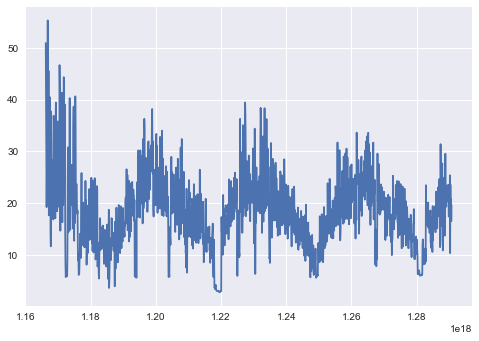

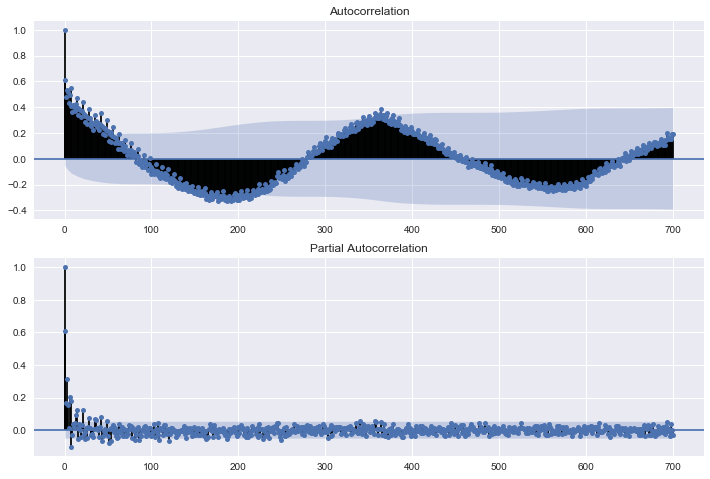

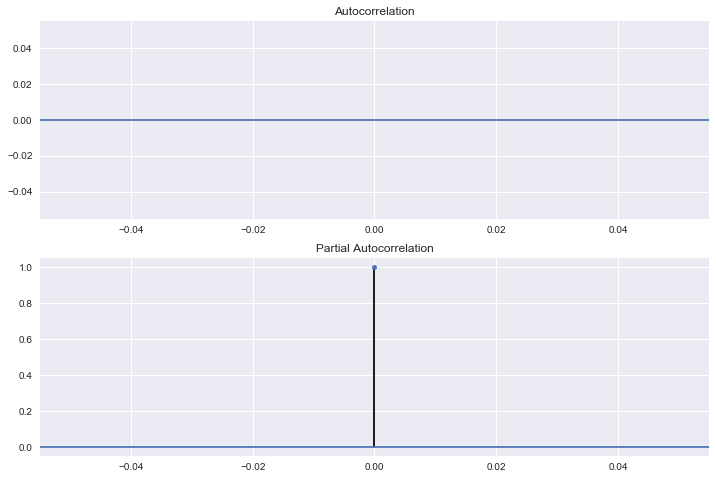

In [24]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.ar_model import AR
from statsmodels.graphics import tsaplots

#load cleaned data and do ts analysis
def parser(x):
    return datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
data_ts = pd.read_csv("cleaned_elec_data.csv", index_col='datetime',date_parser=parser)
ts = data_ts['Global_active_power']
s = ts.resample('d').mean()
sdiff = s.diff()

fig, ax = plt.subplots()
plt.plot(s)
plt.show()

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = tsaplots.plot_acf(s, lags=700, ax=ax1)
ax2 = fig.add_subplot(212)
fig = tsaplots.plot_pacf(s, lags=700, ax=ax2)
plt.show()

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = tsaplots.plot_acf(sdiff, lags=500, ax=ax1)
ax2 = fig.add_subplot(212)
fig = tsaplots.plot_pacf(sdiff, lags=500, ax=ax2)
plt.show()


Sur la première figure, on voit que la série temporelle re-échantillonnée au jour est stationnaire (le test de stationnarité de Dickey-Fuller est concluant) et qu'il semble y avoir une periodicité d'environ un an.
La seconde figure, l'autocorrelation, montre qu'il y a une décroissance oscillante des coefficients et que les coefficients sont dans l'intervalle de confiance à partir d'un retard de 300-400 jours.
La dernière figure, l'autocorrelation partielle montre des coefficients qui décroissent plus vite et pareillement que pour la figure d'autocorrélation, on peut considérer que vers 300-400, les coefficients d'autocorrelation partielle sont nuls.
Ces observations font penser à un modèle autoregressif mais d'ordre très élevé (300-400).
On peut essayer d'utliser l'api de la librairie statsmodels pour construire des modèles AR ou ARMA et utiliser les options des modèles pour trouver les meilleurs paramètres. Malheureusement au vu des ordres élevés qu'ils faut tester, le calcul n'a pas abouti et je n'ai donc pas pu mener cette investigation jusqu'au bout.

Je me suis alors tourné vers une autre méthode. En observant les données j'ai vu que les consommations présentes des caractéristiques différentes suivant qu'on le regarde au niveau de l'année, de la semaine ou de la journée. J'ai donc penser faire une régression en utilisant l'année, le mois, le jour de la semaine et l'heure comme descripteurs catégoriques pour le modèle de regression. J'ai donc choisi de partir sur un modèle d'arbre de décision (qui marche bien pour des données catégoriques) et plus précisement de me concentrer sur un modèle d'ensemble i.e. une forêt d'arbres comme regresseur. 
Après avoir entrainé le modèle sur un set d'entrainement avec une validation croisée, on peut regarder les performances du modèle sur le set de test. Cela nous retourne différentes erreurs, pour la consommation d'énergie, il est plus intéressant de construire un modèle qui va surestimer l'energie nécessaire et pour juger de la performance d'un tel modèle on regarde la métrique RMSLE (root mean squre logarithmic error) qui pénalise de façon plus importante les prédictions ayant une valeur plus faible que l'observation.

En regardant les figures ci-dessous, on voit des variations dans le mois, dans la journée et dans semaine sur la consommation d'energie :

In [75]:
%%HTML
<div class='tableauPlaceholder' id='viz1517215293089' style='position: relative'><noscript><a href='#'><img alt='Sheet 3 ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;el&#47;elec_comsuption&#47;Sheet3&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='elec_comsuption&#47;Sheet3' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;el&#47;elec_comsuption&#47;Sheet3&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='filter' value='publish=yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1517215293089');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>
<div class='tableauPlaceholder' id='viz1517215333688' style='position: relative'><noscript><a href='#'><img alt='Sheet 9 ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;el&#47;elec_comsuption&#47;Sheet9&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='elec_comsuption&#47;Sheet9' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;el&#47;elec_comsuption&#47;Sheet9&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1517215333688');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>
<div class='tableauPlaceholder' id='viz1517215347789' style='position: relative'><noscript><a href='#'><img alt='Sheet 10 ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;el&#47;elec_comsuption&#47;Sheet10&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='elec_comsuption&#47;Sheet10' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;el&#47;elec_comsuption&#47;Sheet10&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1517215347789');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,15 hours 35 mins
H2O cluster version:,3.16.0.2
H2O cluster version age:,1 month and 29 days
H2O cluster name:,H2O_from_python_marcduda_juok6r
H2O cluster total nodes:,1
H2O cluster free memory:,495.6 Mb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"
H2O connection url:,http://localhost:54321
H2O connection proxy:,None


Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%

ModelMetricsRegression: drf
** Reported on test data. **

MSE: 214.30366065074998
RMSE: 14.639114066457369
MAE: 10.318821029991277
RMSLE: 0.7604938366006171
Mean Residual Deviance: 214.30366065074998



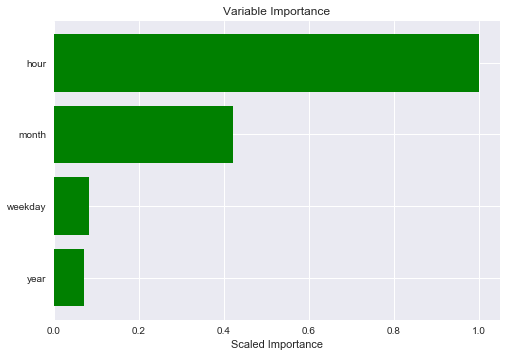

  variable  relative_importance  scaled_importance  percentage
0     hour         2.369680e+09           1.000000    0.634523
1    month         1.000327e+09           0.422136    0.267855
2  weekday         1.978075e+08           0.083474    0.052966
3     year         1.667675e+08           0.070376    0.044655


In [26]:
#%% Modeling
from h2o.estimators.random_forest import H2ORandomForestEstimator

#initiate a h2o cluster and transforme the data into a h2o-specific frame. 
h2o.init(max_mem_size = "2G", nthreads=-1)
if 'Date' in data.columns:
    data.drop(columns=['Date', 'Time'],inplace=True)
col_types=['numeric','numeric','numeric','numeric','numeric','numeric','numeric',
           'time','categorical','categorical','categorical','categorical','categorical']
h2ofr = h2o.H2OFrame(data,column_types=col_types)
#split the data into training, testing and validation sets.
splits = h2ofr.split_frame(ratios=[0.7, 0.15], seed=1)
train = splits[0]
valid = splits[1]
test = splits[2]

#set the columns that while be used as features and the ones we want to predict.
y = 'Global_active_power'
x = list(h2ofr.columns)
x.remove(y) # remove response variable
for z in ['Global_reactive_power','Voltage','Global_intensity', 'Sub_metering_1','Sub_metering_2','Sub_metering_3','datetime','minute']:
    x.remove(z)

#train a random forest regressor on the training set.
RF = H2ORandomForestEstimator(ntrees=50,seed=1,nfolds=5)
RF.train(x=x, y=y, training_frame=train)
#grid_search = H2OGridSearch(H2ORandomForestEstimator, hyper_params=hyper_parameters)
#grid_search.train(x, y, training_frame=train)
#grid_search.show()

#look at the performances of the trained random forest model on the test set.
RF_perf = RF.model_performance(test)
print(RF_perf)

#plot a figure of the variable importances in the trained model. 
fig, ax = plt.subplots()
variables = RF._model_json['output']['variable_importances']['variable']
y_pos = np.arange(len(variables))
scaled_importance = RF._model_json['output']['variable_importances']['scaled_importance']
ax.barh(y_pos, scaled_importance, align='center', color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables)
ax.invert_yaxis()
ax.set_xlabel('Scaled Importance')
ax.set_title('Variable Importance')
plt.show()

#print in the console the variable importances.
print(RF._model_json['output']['variable_importances'].as_data_frame())

#when the model seems to be tuned the best we can, look at the performances on 
#a validation set that was never presented to the model to see if we didn't overfit our
#model on the test set.
#RF_perf = RF.model_performance(valid)
#print(RF_perf)


#shut down the h2o cluster
#h2o.cluster().shutdown()

On voit que les heures influencent le plus le modèle puis viennent les mois puis les jours de la semaine.
On peut optimiser les paramètres du modèle (nombre d'arbres, taille des arbres,...) suivant la métrique RMSLE en utilisant une recherche sur une grille de valeur (GridSearch) ce qui permet de tester toutes les configurations et de trouver la meilleure. Cela n'a pas été possible dans ce cas là à cause d'un bug avec les versions actuelles de h2o et python (H2OServerError: HTTP 500 Server Error).
Si on veut encore un modèle plus performant pour ce cas de figure, on peut tenter un modèle XGBoost par exemple mais il est plus long à entrainer.

Cette approche nous a permit de construire un modèle qui prédit la consommation globale d'energie par heure. On pourrait faire la même chose si on veut prédire séparement les consommations des sous-compteurs et on peut même construire un modèle pour chaque sous-compteur et essayer d'en prédire la consommation globale comme il y a des variations différentes pour chaque sous-compteur.

In [74]:
from keras.models import Sequential
from keras.layers import Dense,LSTM,SimpleRNN, Activation, Dropout
from keras import losses
from sklearn.model_selection import train_test_split
ts = data_ts['Global_active_power']
#make time series start  and stop at a full day
ts = ts['2006-12-17 00:00:00':'2010-11-25 23:59:00']
s = ts.resample('h').mean()
#ts.head()
#ts.tail()
#s.tail()
X=[]
sequence_length = 24
for i in range(0,len(s),sequence_length):
    if len(s[i:i+sequence_length].values)==24:
        X.append(s[i:i+sequence_length].values)
X = np.asarray(X)


print(str(s.shape)+" "+str(X.shape))

X = X-X.mean()
X= X[:, :-1]
y = X[:, -1] 
X_train,X_,y_train,y_ = train_test_split(X,y, test_size=0.30, random_state=42)
X_test,X_valid,y_test,y_valid = train_test_split(X_,y_, test_size=0.50, random_state=42)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
model = Sequential()
#model.add(Embedding(top_words, embedding_vector_length, input_length=max_review_length))
model.add(LSTM(input_shape=(None, 1),units=10,dropout=0.25, recurrent_dropout=0.25))
#model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss=losses.mean_squared_logarithmic_error, optimizer='adam')
# train the model
model.fit(X_train, y_train, batch_size=128, epochs=50, verbose=1,validation_split=0.1)

# evaluate the result
test_msle = model.evaluate(X_test, y_test, verbose=1)
print ('\nThe mean squared logarithmic error (MSLE) on the test data set is %.3f over %d test samples.' % (test_msle, len(y_test)))


(34560,) (1440, 24)
Train on 907 samples, validate on 101 samples
Epoch 1/50
907/907 [==============================] - ETA: 8s - loss: 2.702 - ETA: 3s - loss: 2.666 - ETA: 2s - loss: 2.713 - ETA: 1s - loss: 2.718 - ETA: 0s - loss: 2.811 - ETA: 0s - loss: 2.914 - ETA: 0s - loss: 2.894 - 1s - loss: 2.8902 - val_loss: 2.8171
Epoch 2/50
907/907 [==============================] - ETA: 0s - loss: 3.055 - ETA: 0s - loss: 3.026 - ETA: 0s - loss: 2.923 - ETA: 0s - loss: 2.852 - ETA: 0s - loss: 2.827 - ETA: 0s - loss: 2.770 - ETA: 0s - loss: 2.842 - 0s - loss: 2.8510 - val_loss: 2.7797
Epoch 3/50
907/907 [==============================] - ETA: 0s - loss: 2.820 - ETA: 0s - loss: 2.861 - ETA: 0s - loss: 2.828 - ETA: 0s - loss: 2.836 - ETA: 0s - loss: 2.840 - ETA: 0s - loss: 2.712 - ETA: 0s - loss: 2.826 - 0s - loss: 2.8370 - val_loss: 2.7481
Epoch 4/50
907/907 [==============================] - ETA: 0s - loss: 2.918 - ETA: 0s - loss: 2.880 - ETA: 0s - loss: 2.770 - ETA: 0s - loss: 2.733 - ETA: 0s

907/907 [==============================] - ETA: 0s - loss: 2.678 - ETA: 0s - loss: 2.538 - ETA: 0s - loss: 2.434 - ETA: 0s - loss: 2.419 - ETA: 0s - loss: 2.399 - ETA: 0s - loss: 2.448 - ETA: 0s - loss: 2.410 - 0s - loss: 2.4266 - val_loss: 2.4248
Epoch 33/50
907/907 [==============================] - ETA: 0s - loss: 2.959 - ETA: 0s - loss: 2.641 - ETA: 0s - loss: 2.453 - ETA: 0s - loss: 2.469 - ETA: 0s - loss: 2.518 - ETA: 0s - loss: 2.454 - ETA: 0s - loss: 2.441 - 0s - loss: 2.4256 - val_loss: 2.4223
Epoch 34/50
907/907 [==============================] - ETA: 0s - loss: 2.108 - ETA: 0s - loss: 2.192 - ETA: 0s - loss: 2.336 - ETA: 0s - loss: 2.457 - ETA: 0s - loss: 2.457 - ETA: 0s - loss: 2.467 - ETA: 0s - loss: 2.425 - 0s - loss: 2.4134 - val_loss: 2.4202
Epoch 35/50
907/907 [==============================] - ETA: 0s - loss: 2.991 - ETA: 0s - loss: 2.889 - ETA: 0s - loss: 2.739 - ETA: 0s - loss: 2.505 - ETA: 0s - loss: 2.440 - ETA: 0s - loss: 2.441 - ETA: 0s - loss: 2.437 - 0s - loss